In [1]:
import numpy as np
import random as rn
import os 
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import NoReturn, Text
import warnings
import time

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
%matplotlib inline

# From analysis I found out that final values will be stored near the mean value of ENV file i.e. +-10 percent

I have followed all rules for the agents, scripts have configurable parameters as described in the comptetion site, in visualization i have used both 2d and 3d plots and drawn the figure of geologic environment, location of agents at end of simulation, paths of tracked agents. The last two figures are also made animated where you can zoom and view from any side of the axis. In tracked agents you will see that initially aal the agents are concentrated at a particular plane i.e. z=1249.

In [2]:
### set parameters 
TURNS=2000
AGENTSPERTURN = 100
RANDOMAGENTSGENRATION = 0.25 #random/total
X,Y,Z = 300, 300, 1250 #or use ENV.shape after loading the file ##size of each axis
NO_of_agents_tracked = .50  # 1 indicates 100 percent
Move_preference_matrix = np.zeros((3, 3, 3)) 
Stochastic_move_matrix = np.zeros((3, 3, 3))   #as above 2 matrices neeed not to be stored so I have generated them after each epoch using same method
SEED = 37


In [3]:
## Set seed for random generation
def seed_everything(seed : int) -> NoReturn :
    """To set the see for all potential random number usages. If you are using 
    any other package which might use seed for random generation add it here"""
    rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #tf.random.set_seed(seed)  ##uncomment if you are using tensorflow

seed_everything(SEED)

In [4]:
t0 = time.time()
ENV = np.load("./vol6_environment.npy")#,allow_pickle=False)
print(ENV.shape, ENV.min(), ENV.max())
print("Loading data took {0:0.3f} seconds".format(time.time()-t0))

(300, 300, 1250) 0 255
Loading data took 1.811 seconds


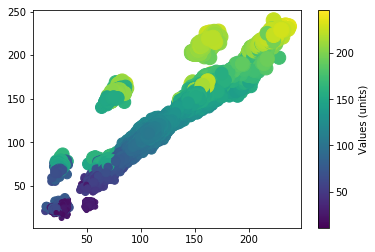

In [5]:
## visualize the volume
x = ENV[:,0]
y = ENV[:,1]
z = ENV[:,2]
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')
pnt3d=ax.scatter(x,y,z,c=z)
cbar=plt.colorbar(pnt3d)
cbar.set_label("Values (units)")
plt.show()

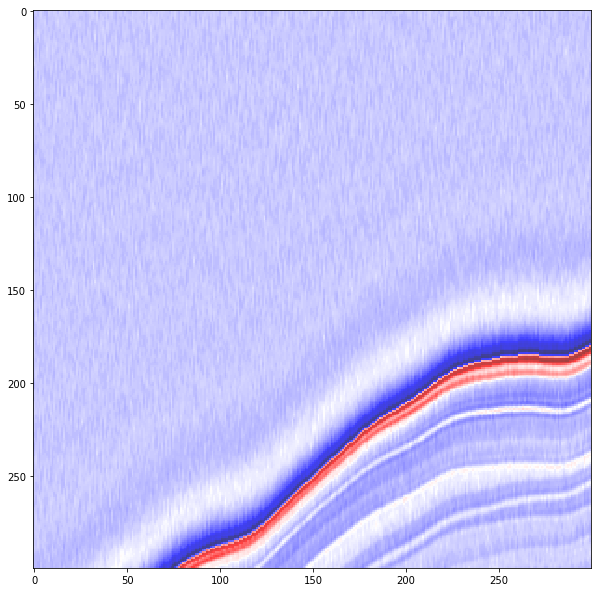

In [6]:
#2D slice through environment and accumulation
ix = 32 ## just select a random plate of the 3D environment 
#plot environment and accumulation 
plt.figure(figsize = (10,20))
plt.imshow(ENV[:, ix, 200:500].T, cmap='seismic', alpha=0.75)
#If you want to plot accumulation, set 0 values to NaN in accumulation for easier viewing
#acc_1 = np.where(acc==1, acc, np.nan)
#plt.imshow(acc_1[:, ix, 200:500].T, )
plt.show()

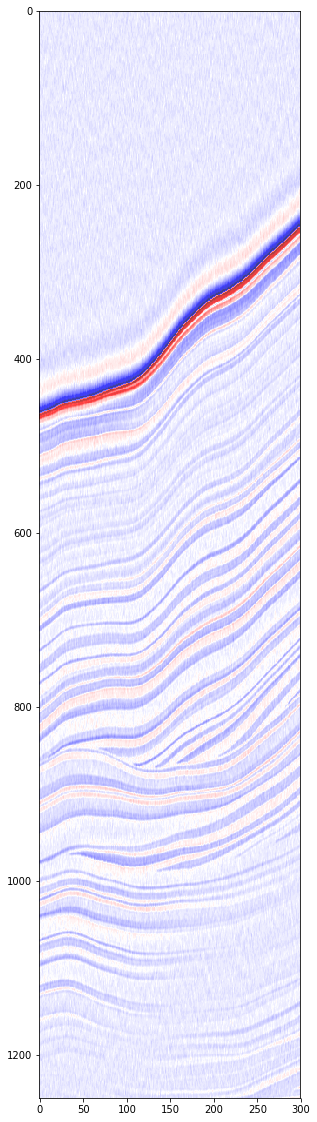

In [7]:
acc=[]
#2D slice through environment and accumulation
ix = 150 ## just select a random plate of the 3D environment 
#plot environment and accumulation 
plt.figure(figsize = (10,20))
plt.imshow(ENV[ ix,:, :].T, cmap='seismic', alpha=0.75)
#If you want to plot accumulation, set 0 values to NaN in accumulation for easier viewing
#acc=ENV2
#acc = np.where(acc==1, acc, np.nan)
#plt.imshow(acc[ ix,:, :].T, )
plt.show()

# If you are not dealing with the Move_preference_matrix and Stochastic_move_matrix dont run the code below instead use the one the below code which has been markdown because it will run nearly twice as fast as the this one

In [11]:
t1 = time.time()
X,Y,Z = ENV.shape  ##size of each axis
curr_x = []
curr_y = []
curr_z = []
curr_x = np.empty(0,dtype=np.int16)
#print(curr_x)
curr_y = np.empty(0,dtype=np.int16)
curr_z = np.empty(0,dtype=np.int16)
occupy = np.zeros((X,Y,Z),dtype = np.int8)
#curr_x = np.load("./m_output_numpy_x800.npy")      #use these code if you want to use the previous checkpoint obtained after running the code below
#curr_y = np.load("./m_output_numpy_y800.npy")
#curr_z = np.load("./m_output_numpy_z80100.npy")
#occupy = np.load("./m_output_numpy800.npy")

prev_x =[] 
prev_y =[]
prev_z =[]
previous_moves= np.zeros((int(NO_of_agents_tracked*TURNS*AGENTSPERTURN) ,TURNS,3),dtype = np.float32)   #previous moves will be stored here
stop = np.zeros((TURNS*AGENTSPERTURN,), dtype=np.int8)         #store which agents are stopped


mean_data_lower = .9*np.mean(ENV)  
mean_data_higher = 1.1*np.mean(ENV)  

for tt in range(TURNS):
    if(tt%5==0):
      print(tt)
    for bb in range(AGENTSPERTURN):
    ##first step generate agents
#    agentID = tt*TURNS+bb
##generating agents
        Start_x = randint(0,X)
        Start_y = randint(0,Y)
        rand_uni = np.random.uniform(0,1)
        if (rand_uni<RANDOMAGENTSGENRATION):                
          Start_z = randint(0,Z)
        else:
          Start_z = Z-1
        while (occupy[Start_x][Start_y][Start_z]==1):
            Start_x = randint(0,X)
            Start_y = randint(0,Y)
            if(Start_z != Z-1):
              Start_z = randint(0,Z)
        occupy[Start_x][Start_y][Start_z]=1
#storing the new generated data at each turn        
        curr_x = np.append(curr_x,(Start_x)) 
        curr_y = np.append(curr_y,(Start_y))
        curr_z = np.append(curr_z,(Start_z))
        for prev_i in range(0,min(len(curr_x),len(previous_moves))):
          previous_moves[prev_i][tt][0] = curr_x[prev_i]
          previous_moves[prev_i][tt][1] = curr_y[prev_i]
          previous_moves[prev_i][tt][2] = curr_z[prev_i]
    for i in range(0,len(curr_x)):
    #    p,q,r = check17(curr_x[i],curr_y[i],curr_z[i],i)
        if (stop[i]==-1):
          continue
        l = curr_x[i]
        m = curr_y[i]
        n = curr_z[i]
        p=l
        q=m
        r=n
        t=0
        moves =[]
        rand_uni2 = np.random.uniform(0,1)
        if rand_uni2<.1:           #if next move is random 
          p = l + randint(-1,2)
          q = m + randint(-1,2)
          r = n - randint(0,2)
          if (p==l and q==m and r==n):
            p = l + randint(-1,2)
            q = m + randint(-1,2)
            r = n - randint(0,2)
          if ( (p >=0 and p<X) and (q >=0 and q<Y) and (r >=0 and r<Z)):
            if(occupy[p][q][r]==1):
              p = l + randint(-1,2)
              q = m + randint(-1,2)
              r = n - randint(0,2)
              if ( (p >=0 and p<X) and (q >=0 and q<Y) and (r >=0 and r<Z)):    #decreasing the probability to die as molecule is more likely to travel than stay
                if(occupy[p][q][r]==1):
                  stop[i] = -1
                  continue
              else:
                stop[i] = -1
                continue

          else:
            stop[i] = -1
            continue
          t = 1 

        else:            #if molecule movement is not random
          Move_preference_matrix = np.zeros((3, 3, 3))     #after calculation zero will indicate that molecule will not move to that location
          Stochastic_move_matrix = np.zeros((3, 3, 3))
          sss=0
          
          for kk in range(0,2):
            for ii in range(-1,2):
                for jj in range(-1,2):
                  lii = l+ii
                  mjj = m+jj
                  nkk = n-kk
                  if (kk==0 and ii==0 and jj==0):
                    Move_preference_matrix[ii+1][jj+1][kk+1] = -1   #here -1 denotes agent current location
                    Stochastic_move_matrix[ii+1][jj+1][kk+1] = -1   #here -1 denotes agent current location
                    continue

                  if (lii >=0 and lii<X and mjj >=0 and mjj<Y and nkk >=0 and nkk<Z):
 
                    moves.append(ENV[lii][mjj][nkk])
                    Stochastic_move_matrix[ii+1][jj+1][kk+1] = 1/ENV[lii][mjj][nkk]

          moves_reciprocal = np.reciprocal(moves,dtype = float) 
          Stochastic_move_matrix = (Stochastic_move_matrix*100)/(sum(moves_reciprocal))
          moves.sort()
          for kk in range(0,2):
            for ii in range(-1,2):
                for jj in range(-1,2):
                  lii = l+ii
                  mjj = m+jj
                  nkk = n-kk
                  if (kk==0 and ii==0 and jj==0):
                    continue

                  if (lii >=0 and lii<X and mjj >=0 and mjj<Y and nkk >=0 and nkk<Z):
                    for moves_i in range(0,len(moves)):
                      if(moves[moves_i] == ENV[lii][mjj][nkk]):               #maximum number will denote first preference
                        Move_preference_matrix[ii+1][jj+1][kk+1] = moves_i     #setting the preference order
                        break
                   

                  if (lii >=0 and lii<X and mjj >=0 and mjj<Y and nkk >=0 and nkk<Z):          #insted of going through a whole loop I am saving the most prefered next move positions here only including the condition if there is no prefered move available
                    aqw = ENV[lii][mjj][nkk]
                    if (occupy[lii][mjj][nkk]==0 and aqw>=mean_data_lower and aqw < mean_data_higher):
                      if (sss==0):
                        minv =  occupy[lii][mjj][nkk]
                        p=lii
                        q=mjj
                        r=nkk
                        t=1
                        sss = 1
                      else:
                        if(ENV[p][q][r]>=aqw):
                            p=lii
                            q=mjj
                            r=nkk
                            t=1
                            stop[i]=0
                  else:
                    if(t==0):
                      stop[i]=-1
                    
        if (t==0):
          if(n-1>=0):
            if(occupy[l][m][n-1]==0):
              stop[i] = 0
              r=curr_z[i]-1
        if ((l==p and m==q and n==r) or r == 0):
          stop[i] = -1
        occupy[l][m][n]=0
        occupy[p][q][r]=1
 
   
            
        curr_x[i]=p
        curr_y[i]=q
        curr_z[i]=r
    if (tt+1==TURNS):
      for prev_i in range(0,min(len(curr_x),len(previous_moves))):
        previous_moves[prev_i][tt][0] = curr_x[prev_i]
        previous_moves[prev_i][tt][1] = curr_y[prev_i]
        previous_moves[prev_i][tt][2] = curr_z[prev_i]
    if((tt+1)%400==0):                                      #checkpoints in order to analyse data and resume from the last checkpoint
      np.save('8_output_numpy'+str(tt+1),occupy)
      np.save('8_output_numpy_x'+str(tt+1),curr_x)
      np.save('8_output_numpy_y'+str(tt+1),curr_y)
      np.save('8_output_numpy_z'+str(tt+1),curr_z)
      np.save('8_output_numpy_z'+str(tt+1),curr_z)
      print('aaa',np.sum(stop))
      print(time.time()-t1)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


KeyboardInterrupt: 

In [12]:
Move_preference_matrix

array([[[ 0., 12., 12.],
        [ 0.,  6.,  9.],
        [ 0., 12., 12.]],

       [[ 0.,  9.,  6.],
        [ 0., -1.,  0.],
        [ 0.,  5.,  6.]],

       [[ 0.,  1.,  3.],
        [ 0.,  1.,  3.],
        [ 0., 12.,  9.]]])

In [13]:
Stochastic_move_matrix

array([[[   0.        ,    5.75074706,    5.75074706],
        [   0.        ,    5.85436413,    5.80209302],
        [   0.        ,    5.75074706,    5.75074706]],

       [[   0.        ,    5.80209302,    5.85436413],
        [   0.        , -649.83441799,    6.18889922],
        [   0.        ,    5.90758562,    5.85436413]],

       [[   0.        ,    6.07321886,    6.01698535],
        [   0.        ,    6.07321886,    6.01698535],
        [   0.        ,    5.75074706,    5.80209302]]])

In [14]:
sum(sum(sum(Stochastic_move_matrix)))

-549.8344179854203

In [15]:
previous_moves.shape

(100000, 2000, 3)

# If you are not dealing with the Move_preference_matrix and Stochastic_move_matrix use the code below instead of above one the below code will run nearly twice as fast as the above one

t1 = time.time()
X,Y,Z = ENV.shape  ##size of each axis
curr_x = []
curr_y = []
curr_z = []
curr_x = np.empty(0,dtype=np.int16)
#print(curr_x)
curr_y = np.empty(0,dtype=np.int16)
curr_z = np.empty(0,dtype=np.int16)
occupy = np.zeros((X,Y,Z),dtype = np.int8)
#curr_x = np.load("./m_output_numpy_x800.npy")      #use these code if you want to use the previous checkpoint obtained after running the code below
#curr_y = np.load("./m_output_numpy_y800.npy")
#curr_z = np.load("./m_output_numpy_z80100.npy")
#occupy = np.load("./m_output_numpy800.npy")

prev_x =[] 
prev_y =[]
prev_z =[]
previous_moves= np.zeros((int(NO_of_agents_tracked*TURNS*AGENTSPERTURN) ,TURNS,3),dtype = np.float32)   #previous moves will be stored here
stop = np.zeros((TURNS*AGENTSPERTURN,), dtype=np.int8)         #store which agents are stopped


mean_data_lower = .9*np.mean(ENV)  
mean_data_higher = 1.1*np.mean(ENV)  

for tt in range(TURNS):
    if(tt%5==0):
      print(tt)
    for bb in range(AGENTSPERTURN):
    ##first step generate agents
#    agentID = tt*TURNS+bb
##generating agents
        Start_x = randint(0,X)
        Start_y = randint(0,Y)
        rand_uni = np.random.uniform(0,1)
        if (rand_uni<RANDOMAGENTSGENRATION):                
          Start_z = randint(0,Z)
        else:
          Start_z = Z-1
        while (occupy[Start_x][Start_y][Start_z]==1):
            Start_x = randint(0,X)
            Start_y = randint(0,Y)
            if(Start_z != Z-1):
              Start_z = randint(0,Z)
        occupy[Start_x][Start_y][Start_z]=1
#storing the new generated data at each turn        
        curr_x = np.append(curr_x,(Start_x)) 
        curr_y = np.append(curr_y,(Start_y))
        curr_z = np.append(curr_z,(Start_z))
        for prev_i in range(0,min(len(curr_x),len(previous_moves))):
          previous_moves[prev_i][tt][0] = curr_x[prev_i]
          previous_moves[prev_i][tt][1] = curr_y[prev_i]
          previous_moves[prev_i][tt][2] = curr_z[prev_i]
    for i in range(0,len(curr_x)):
    #    p,q,r = check17(curr_x[i],curr_y[i],curr_z[i],i)
        if (stop[i]==-1):
          continue
        l = curr_x[i]
        m = curr_y[i]
        n = curr_z[i]
        p=l
        q=m
        r=n
        t=0
        moves =[]
        rand_uni2 = np.random.uniform(0,1)
        if rand_uni2<.1:           #if next move is random 
          p = l + randint(-1,2)
          q = m + randint(-1,2)
          r = n - randint(0,2)
          if (p==l and q==m and r==n):
            p = l + randint(-1,2)
            q = m + randint(-1,2)
            r = n - randint(0,2)
          if ( (p >=0 and p<X) and (q >=0 and q<Y) and (r >=0 and r<Z)):
            if(occupy[p][q][r]==1):
              p = l + randint(-1,2)
              q = m + randint(-1,2)
              r = n - randint(0,2)
              if ( (p >=0 and p<X) and (q >=0 and q<Y) and (r >=0 and r<Z)):    #decreasing the probability to die as molecule is more likely to travel than stay
                if(occupy[p][q][r]==1):
                  stop[i] = -1
                  continue
              else:
                stop[i] = -1
                continue

          else:
            stop[i] = -1
            continue
          t = 1 

        else:            #if molecule movement is not random
          
          sss=0
          
         

          for kk in range(0,2):
            for ii in range(-1,2):
                for jj in range(-1,2):
                  lii = l+ii
                  mjj = m+jj
                  nkk = n-kk
                  if (kk==0 and ii==0 and jj==0):
                    continue

                   

                  if (lii >=0 and lii<X and mjj >=0 and mjj<Y and nkk >=0 and nkk<Z):          #insted of going through a whole loop I am saving the most prefered next move positions here only including the condition if there is no prefered move available
                    aqw = ENV[lii][mjj][nkk]
                    if (occupy[lii][mjj][nkk]==0 and aqw>=mean_data_lower and aqw < mean_data_higher):
                      if (sss==0):
                        minv =  occupy[lii][mjj][nkk]
                        p=lii
                        q=mjj
                        r=nkk
                        t=1
                        sss = 1
                      else:
                        if(ENV[p][q][r]>=aqw):
                            p=lii
                            q=mjj
                            r=nkk
                            t=1
                            stop[i]=0
                  else:
                    if(t==0):
                      stop[i]=-1
                    
        if (t==0):
          if(n-1>=0):
            if(occupy[l][m][n-1]==0):
              stop[i] = 0
              r=curr_z[i]-1
        if ((l==p and m==q and n==r) or r == 0):
          stop[i] = -1
        occupy[l][m][n]=0
        occupy[p][q][r]=1

       
        curr_x[i]=p
        curr_y[i]=q
        curr_z[i]=r
    if (tt+1==TURNS):
      for prev_i in range(0,min(len(curr_x),len(previous_moves))):
        previous_moves[prev_i][tt][0] = curr_x[prev_i]
        previous_moves[prev_i][tt][1] = curr_y[prev_i]
        previous_moves[prev_i][tt][2] = curr_z[prev_i]
    if((tt+1)%400==0):                                      #checkpoints in order to analyse data and resume from the last checkpoint
   #   np.save('8_output_numpy'+str(tt+1),occupy)
   #   np.save('8_output_numpy_x'+str(tt+1),curr_x)          #use them if you want to analyse the behaviour of save the intermediate steps
   #   np.save('8_output_numpy_y'+str(tt+1),curr_y)
    #  np.save('8_output_numpy_z'+str(tt+1),curr_z)
    #  np.save('8_previous_moves'+str(tt+1),previous_moves)
      print('aaa',np.sum(stop))
      print(time.time()-t1)

# initially location of agents at end of simulation  is shown  and at the end an animation Shows paths of tracked agents, also combined accumulations and environment in a 2d fig were also tracked

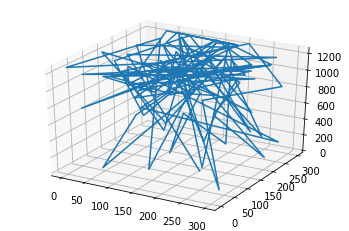

In [16]:
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
'''
v= np.array([[1,2,3], [4,5,6], [7,8,9]])
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(curr_x[:100],curr_y[:100],curr_z[:100])
plt.show()

In [17]:

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['figure.dpi'] = 50

<IPython.core.display.Javascript object>


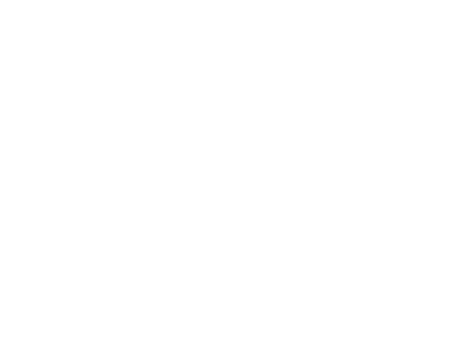

<IPython.core.display.Javascript object>


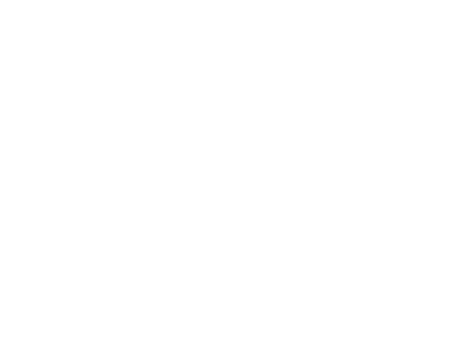

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot(curr_x[:100],curr_y[:100],curr_z[:100])
ax.scatter(curr_x,curr_y,curr_z, c = np.linalg.norm([curr_x,curr_y,curr_z],axis = 0))
plt.show()

<IPython.core.display.Javascript object>


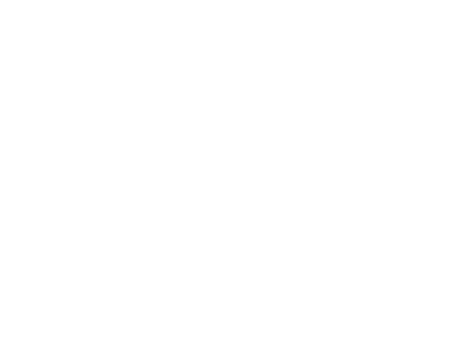

<IPython.core.display.Javascript object>


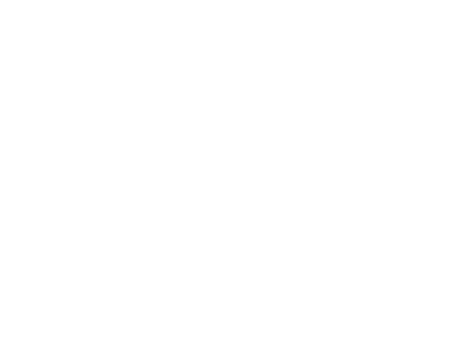

In [19]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
#ax.plot(curr_x[:100],curr_y[:100],curr_z[:100])
ax.scatter(curr_x,curr_y,curr_z, cmap='seismic', alpha=0.75)
plt.show()

In [20]:
import ipyvolume as ipv

In [21]:
fig = ipv.figure()
scatter = ipv.scatter(curr_x[:100],curr_y[:100],curr_z[:100], marker = 'sphere')      #for final positions
ipv.show()

In [22]:
curr_x.shape

(19700,)

In [23]:
import ipywidgets as widgets
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [24]:
scatter.geo = 'box'

In [25]:
w = widgets.ToggleButtons(options = ['arrow', 'sphere', 'diamond','box'])
widgets.link((scatter,'geo'),(w, 'value'))
w

ToggleButtons(index=3, options=('arrow', 'sphere', 'diamond', 'box'), value='box')

In [26]:
scatter.size = 3

In [27]:
slider = widgets.FloatSlider(min = 0.0, max = 10, step = 0.1)
widgets.jslink((scatter, 'size'), (slider, 'value'))
slider

FloatSlider(value=0.0, max=10.0)

In [28]:
previous_x=[]
previous_y=[]
previous_z=[]
j=0
for i in range(0,len(previous_moves)):
    previous_x.append(previous_moves[i][j][0])
    previous_y.append(previous_moves[i][j][1])
    previous_z.append(previous_moves[i][j][2])
#wx = previous_x.astype(int)
x = np.array(previous_x, dtype=np.float)
y = np.array(previous_y, dtype=np.float)
z = np.array(previous_z, dtype=np.float)
#wz = previous_z[:]

In [29]:
previous_moves.shape

(100000, 2000, 3)

In [30]:
fig = ipv.figure()

scatter = ipv.scatter(x,y,z, marker = 'sphere')
ipv.show()

In [31]:
for j in range(0,TURNS):
    previous_x=[]
    previous_y=[]
    previous_z=[]
    if(j%200==0):
        print(j)
    for i in range(0,len(previous_moves)):
        previous_x.append(previous_moves[i][j][0])
        previous_y.append(previous_moves[i][j][1])
        previous_z.append(previous_moves[i][j][2])
    scatter.x = np.array(previous_x, dtype=np.float)
    scatter.y = np.array(previous_y, dtype=np.float)
    scatter.z = np.array(previous_z, dtype=np.float)

0


KeyboardInterrupt: 

In [32]:
resultsDF = pd.DataFrame(columns=['x','y','z']) 
resultsDF = resultsDF.astype(dtype={'x': np.int16,
                                    'y': np.int16,'z': np.int16})
resultsDF['x'] = curr_x
resultsDF['y'] = curr_y
resultsDF['z'] = curr_z
print(len(resultsDF))
resultsDF.head(150)

19700


,x,y,z
0,120,95,1168
1,280,177,1199
2,194,42,1146
3,102,94,731
4,288,281,149
5,67,110,1155
6,122,22,1147
7,267,193,1227
8,181,84,1147
9,297,23,1210


In [ ]:
acc=[]
#2D slice through environment and accumulation
ix = 1100 ## just select a random plate of the 3D environment 
#plot environment and accumulation 
plt.figure(figsize = (10,20))
plt.imshow(ENV[ 150,:, :].T, cmap='seismic', alpha=0.75)
#If you want to plot accumulation, set 0 values to NaN in accumulation for easier viewing
acc=occupy
acc = np.where(acc==1, acc, np.nan)
plt.imshow(acc[ 150 ,:, :].T, )
plt.show()

In [ ]:
#For evaluation please save these columns only End_x, End_y, End_z
resultsDF[["x","y","z"]].to_csv("submission.csv",index=False)

In [ ]:
#if using google colab you can download it as:
from google.colab import files
files.download("submission.csv")